In [1]:
import numpy as np
import torch
import re


from matplotlib import pyplot as plt

import const
from outlier_detector import OutlierDetector, InstanceConfidenceCalculator
from dump_inference_results import model_dirs


/home/fu/.virtualenvs/captcha-rsSqJZ6U/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[PosixPath('results/recognizer/capitalized+capital-color'), PosixPath('results/recognizer/captcha-09az+capital-color'), PosixPath('results/recognizer/captcha-09az+capitalized'), PosixPath('results/recognizer/captcha-images+capital-color'), PosixPath('results/recognizer/captcha-images+capitalized'), PosixPath('results/recognizer/captcha-images+captcha-09az')]


In [2]:
def load_npz_all(npz_dir, model_name, train):
    if train:
        suffix = 'train'
    else:
        suffix = 'test'
    npz_paths = list(npz_dir.glob('{}__*-{}.npz'.format(model_name, suffix)))

    rtn = dict()

    for npz_path in npz_paths:
        dataset_name = re.search(r'__(.*)-{}'.format(suffix), str(npz_path)).groups(0)[0]
        npz = np.load(npz_path)
        rtn[dataset_name] = {
            'known': dataset_name in model_name
        }
        rtn[dataset_name].update(npz)
    return rtn

outlier_detectors = dict()
instance_confidence_calculators = dict()

for d in model_dirs:
    model_name = d.name
    npz_all = load_npz_all(const.NPZ_DIR, model_name, True)
    known_mid = list()
    unknown_mid = list()
    positive_y = list()
    negative_y = list()
    _ACS = np.array(const.ALL_CHAR_SET)
    for _, npz in npz_all.items():
        if npz['known']:
            known_mid.append(npz['middles'])
            c = [''.join(_ACS[y.argmax(axis=0)]) for y in npz['ys']]
            # use label information only from training dataset
            positive_y.append(npz['ys'][c == npz['labels']])
            negative_y.append(npz['ys'][c != npz['labels']])
        else:
            unknown_mid.append(npz['middles'])
    outlier_detectors[model_name] = OutlierDetector(known_mid, unknown_mid)
    instance_confidence_calculators[model_name] = InstanceConfidenceCalculator(positive_y, negative_y)

0.4043 0.1763


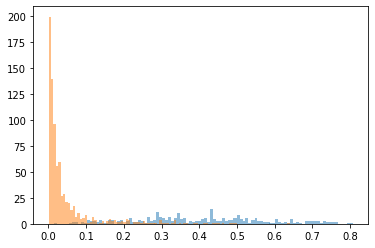

0.567 0.2008


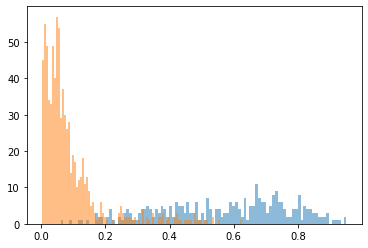

0.627 0.2029


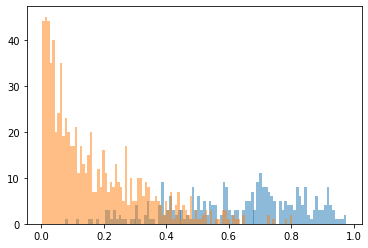

0.635 0.1876


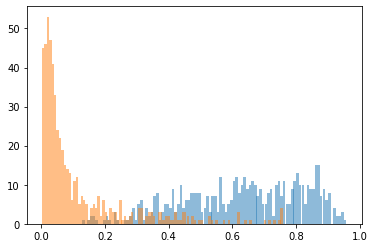

0.567 0.2012


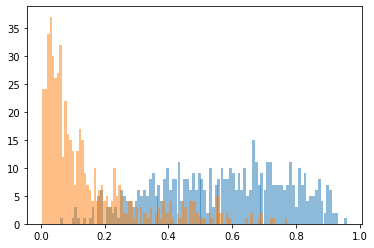

0.6177 0.1964


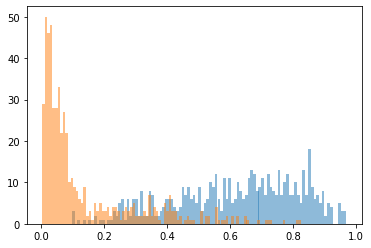

In [3]:
if True:
    for model_path in model_dirs:
        model_name = model_path.name
        ic = instance_confidence_calculators[model_name]
        npz_all = load_npz_all(const.NPZ_DIR, model_name, False)
        positive_y = list()
        negative_y = list()
        #print(npz_all)
        for npz in npz_all.values():
            c = [''.join(_ACS[y.argmax(axis=0)]) for y in npz['ys']]
            positive_y.append(npz['ys'][c == npz['labels']])
            negative_y.append(npz['ys'][c != npz['labels']])

        scores = ic.calc_score(np.concatenate(positive_y))
        plt.hist(scores, alpha=0.5, color='tab:blue', bins=100)
        print(scores.mean(), scores.std())
        scores = ic.calc_score(np.concatenate(negative_y))
        plt.hist(scores, alpha=0.5, color='tab:orange', bins=100)
        plt.show()

```
def test(data_dir, model):
    dataloader = my_datasets.get_dataloader(data_dir, 64, False, 15)

    _ACS = np.array(const.ALL_CHAR_SET)
    model.eval()
    n_sample = len(dataloader.dataset) if len(dataloader.dataset) < 50 else 50
    with torch.no_grad():
        fig = plt.figure(figsize=(6, 3*n_sample))
        for img, _, label in dataloader:
            img = img[:n_sample].cuda()
            pred = model(img).reshape((-1, len(const.ALL_CHAR_SET), const.MAX_CAPTCHA)).cpu()
            c = [''.join(line) for line in _ACS[pred.argmax(axis=1)]]

            for i, (im, y, t) in enumerate(zip(img, c, label)):
                ax = fig.add_subplot(n_sample, 2, 2*i+1)
                #ax.imshow(im[0].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                ax.imshow(im.cpu().numpy().transpose(1,2,0))

                ax = fig.add_subplot(n_sample, 2, 2*i+2)
                for pos in 'top right left bottom'.split():
                    ax.spines[pos].set_visible(False)
                ax.tick_params('x', length=0, which='major')
                ax.tick_params('y', length=0, which='major')

                color = 'black' if y == t else 'red'
                ax.text(0.5, 0.5, '{} {}'.format(y, t), dict(color=color))
            break
```


In [4]:
#outlier_detector.test()

In [5]:
model_dir = model_dirs[2]
model_name = model_dir.name

npz_all = load_npz_all(const.NPZ_DIR, model_name, False)
o_detector = outlier_detectors[model_name]
i_calculator = instance_confidence_calculators[model_name]

_ACS = np.array(const.ALL_CHAR_SET)


for i, (datset_name, npz) in enumerate(npz_all.items()):
    ys, labels, middles = npz['ys'], npz['labels'], npz['middles']
    #indv_confs = ys.max(axis=1).mean(axis=1)
    indv_confs = i_calculator.calc_score(ys)
    domain_confs = o_detector.calc_score(middles) 
    for i, y, label, indv_conf, domain_conf in zip(range(100), ys, labels, indv_confs, domain_confs):
        c = ''.join(_ACS[y.argmax(axis=0)])
        print('label: {}, y: {}, correct?: {}'.format(label, c, label == c))
        print('conf_indv: {}, conf_domain: {}'.format(indv_conf, domain_conf))




label: smlt4, y: mwwwm, correct?: False
conf_indv: 0.43994140625, conf_domain: -5.603255619952391
label: sybe3, y: mwwwm, correct?: False
conf_indv: 0.27587890625, conf_domain: -6.810958242184623
label: khcys, y: mw8wm, correct?: False
conf_indv: 0.237060546875, conf_domain: -7.225657224643105
label: xqxr7, y: mwwwm, correct?: False
conf_indv: 0.267333984375, conf_domain: -6.492331771748309
label: 5qehj, y: mwwwm, correct?: False
conf_indv: 0.4755859375, conf_domain: -6.167950707058523
label: syd9c, y: mwwwm, correct?: False
conf_indv: 0.32080078125, conf_domain: -6.570875870071407
label: tef2k, y: mwwwm, correct?: False
conf_indv: 0.266845703125, conf_domain: -5.891399547259794
label: wm2sc, y: mwwwm, correct?: False
conf_indv: 0.284423828125, conf_domain: -6.412379206146249
label: apcdb, y: mwwwm, correct?: False
conf_indv: 0.195556640625, conf_domain: -6.52186157802967
label: bbtky, y: mwwwk, correct?: False
conf_indv: 0.5673828125, conf_domain: -5.844341184793674
label: 77cxe, y: m

results/recognizer/capitalized+capital-color


<Figure size 432x288 with 0 Axes>

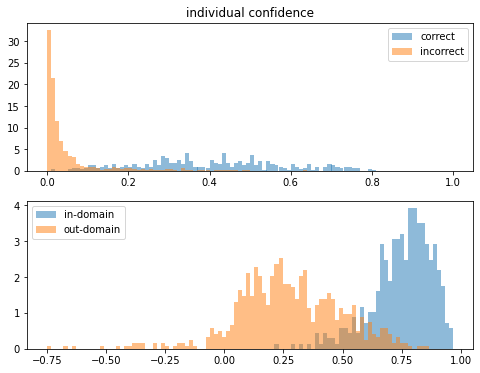

results/recognizer/captcha-09az+capital-color


<Figure size 432x288 with 0 Axes>

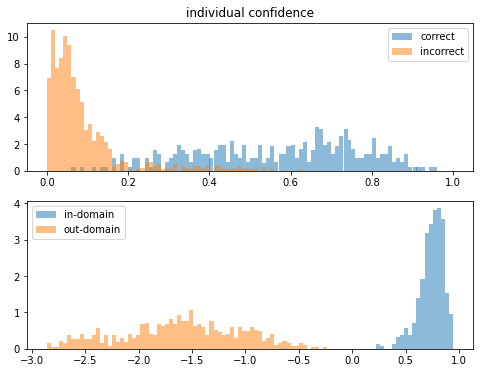

results/recognizer/captcha-09az+capitalized


<Figure size 432x288 with 0 Axes>

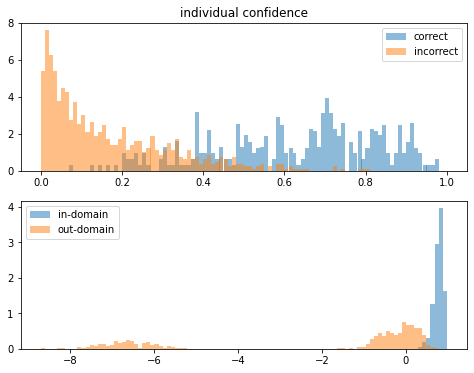

results/recognizer/captcha-images+capital-color


<Figure size 432x288 with 0 Axes>

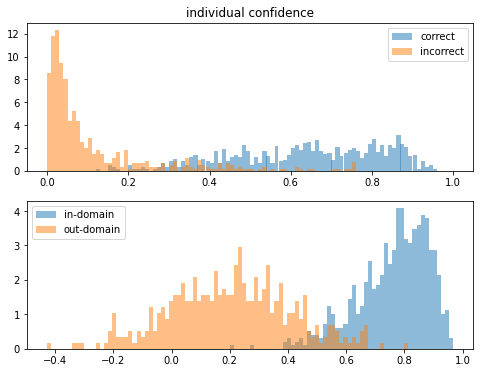

results/recognizer/captcha-images+capitalized


<Figure size 432x288 with 0 Axes>

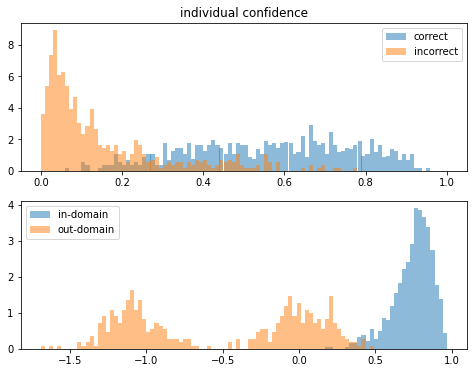

results/recognizer/captcha-images+captcha-09az


<Figure size 432x288 with 0 Axes>

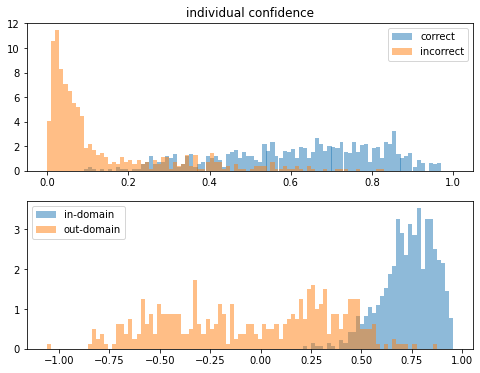

In [8]:
from matplotlib import pyplot as plt

def plot_confs(model_name):
    npz_all = load_npz_all(const.NPZ_DIR, model_name, False)
    o_detector = outlier_detectors[model_name]
    i_calculator = instance_confidence_calculators[model_name]

    _ACS = np.array(const.ALL_CHAR_SET)

    plt.clf()
    fig = plt.figure(figsize=(4*2,3*2))
    correct_indv_confs = list()
    incorrect_indv_confs = list()
    known_domain_confs = list()
    unknown_domain_confs = list()


    for i, (datset_name, npz) in enumerate(npz_all.items()):
        ys, labels, middles = npz['ys'], npz['labels'], npz['middles']
        answers = [''.join(_ACS[y.argmax(axis=0)]) for y in ys]
        #indv_confs = ys.max(axis=1).mean(axis=1)
        indv_confs = i_calculator.calc_score(ys)
        domain_confs = o_detector.calc_score(middles)
        domain_confs[domain_confs < 0] = 0
        domain_confs[domain_confs > 1] = 1
        
        if True:
            correct_indv_confs.append(indv_confs[labels == answers])
            incorrect_indv_confs.append(indv_confs[labels != answers])
        elif npz['known']:
            correct_indv_confs.append(indv_confs[(labels == answers)])
            incorrect_indv_confs.append(indv_confs[labels != answers])
            print(indv_confs.shape)
        if npz['known']:
            known_domain_confs.append(domain_confs)
        else:
            unknown_domain_confs.append(domain_confs)
    ax = fig.add_subplot(2,1,1)
    ax.set_title('individual confidence')
    ax.hist(np.hstack(correct_indv_confs), range=(0, 1), alpha=0.5, bins=100, color='tab:blue', label='correct', density=True)
    ax.hist(np.hstack(incorrect_indv_confs), range=(0, 1), alpha=0.5, bins=100, color='tab:orange', label='incorrect', density=True)
    ax.legend()

    ax = fig.add_subplot(2,1,2)
    known_domain_confs = np.hstack(known_domain_confs)
    unknown_domain_confs = np.hstack(unknown_domain_confs)
    min_conf = min(known_domain_confs.min(), unknown_domain_confs.min())
    max_conf = max(known_domain_confs.max(), unknown_domain_confs.max())
    ax.hist(known_domain_confs, range=(min_conf, max_conf), alpha=0.5, bins=100, color='tab:blue', label='in-domain', density=True)
    ax.hist(unknown_domain_confs, range=(min_conf, max_conf), alpha=0.5, bins=100, color='tab:orange', label='out-domain', density=True)
    ax.legend()
    plt.show()

for p in model_dirs:
    print(p)
    plot_confs(p.name)


In [7]:
def calc_confidence_distribution(data_dir, model):
    dataloader = my_dataset.get_dataloader(data_dir, 64, False)

    _ACS = np.array(const.ALL_CHAR_SET)
    model.eval()
    rtn = list()
    with torch.no_grad():
        for img, _, _ in dataloader:
            img = img.cuda()
            pred = model(img).reshape((-1, len(const.ALL_CHAR_SET), const.MAX_CAPTCHA)).cpu()
            q = torch.nn.functional.softmax(pred, dim=1).max(dim=1)[0].mean(dim=1)
            rtn.append(q)
    return torch.concat(rtn), len(dataloader.dataset)
    
model_path = model_paths[0]
model.load_state_dict(torch.load(str(model_path), map_location='cuda:0'))


fig = plt.figure()

for i, dl in enumerate(train_dataloaders):
    q, n = calc_confidence_distribution(dl, model)
    q_mean, q_std = q.mean(), q.std()
    print(q_mean - 2*q_std, q_mean + 2*q_std)
    ax = fig.add_subplot(len(test_dataloaders), 1, i+1)
    ax.hist(q, range=(0, 1), bins=100)



NameError: name 'model_paths' is not defined

In [ ]:
model_path = model_paths[0]
model.load_state_dict(torch.load(str(model_path), map_location='cuda:0'))


fig = plt.figure()

for i, dl in enumerate(test_dataloaders):
    q, n = calc_confidence_distribution(dl, model)
    q_mean, q_std = q.mean(), q.std()
    print(q_mean - 2*q_std, q_mean + 2*q_std)
    ax = fig.add_subplot(len(test_dataloaders), 1, i+1)
    ax.hist(q, range=(0, 1), bins=100)

